Started May 25, 2017

In [1]:
# RUN THIS FIRST

%matplotlib inline

from __future__ import division
from matplotlib import pyplot as plt
import numpy as np

import sys
sys.path.append('..')
import util

# Objectives

Use first and second moment methods to find the "threshold" size in which it will be asymptotically certain that there will or will not be a repeated substring in the generalized string. Here I try to take many of the same approaches taken in "Unambiguous Threading of Random Text from Overlapping Substrings".

## First Moment Method

#### Overview
For this, I take an analogous approach the paper on finding the longest k-mer. To start let

$$
Y_k = \sum_{i} ind(G[1:k] \cap G[i:k] \neq \emptyset)
$$

Here $ind$ represents the indicator function (can't figure out how to import LaTeX packages on here yet), $i \in k \mathcal{R}$, and $i > 1$ (i.e. check non-overlapping chunks of $G$ with first prefix chunk). Furthermore, $G[1:k] \cap G[i:k] \neq \emptyset$ is simply shorthand for $G[1 + r] \cap G[i + r] \neq \emptyset$ $\forall r \in \{0, 1, \ldots, k - 1\}$.

Using the first moment method one notes that...

$$
P(\textrm{Exists a k-length substring matching with prefix}) \ge P(Y_k \ge 0) \ge \frac{E[Y_k]^2}{E[Y_k^2]}
$$

#### Calculating Lower Bound

* First we find $E[Y_k]$. Note that this is simply the probability that a fixed generalized substring matches with the prefix. To match notation in the k-mer paper, let $c_2$ be the probability that any two non-empty subsets of the alphabet selected uniformly at random have at least one element in common (this probability will be given later). Where $n$ is the length of $G$...

$$
E[Y_k] = \left( \lfloor \frac{n}{k} \rfloor - 1\right) c_2^k
$$

Since there are $\lfloor \frac{n}{k} \rfloor - 1$ possible values that $i$ can take.

* Looking at $E[Y_k^2]$ note that...

$$
Y_k^2 = \sum_{i, j} ind(G[1:k] \cap G[i:k] \neq \emptyset) ind(G[1:k] \cap G[j:k] \neq \emptyset)
$$

$$
= \sum_{i = j} ind(G[1:k] \cap G[i:k] \neq \emptyset) + \sum_{i \neq j} ind(G[1:k] \cap G[i:k] \neq \emptyset) ind(G[1:k] \cap G[j:k] \neq \emptyset)
$$

Let $c_{1, 2}$ be the probability that two non-empty subsets of the alphabet, each chosen uniformly at random, both share an element with a third non-empty subset of the alphabet chosen uniformly at random (e.g. $G[1] \cap G[i] \neq \emptyset$ and $G[1] \cap G[j] \neq \emptyset$). Then one sees that...

$$
E[Y_k^2] = \left( \lfloor \frac{n}{k} \rfloor - 1\right) c_2^k + \left( \lfloor \frac{n}{k} \rfloor - 1 \right) \left( \lfloor \frac{n}{k} \rfloor - 2 \right) c_{1, 2}^k
$$

In the hopes that the lower bound goes to 1, the following is observed...

$$
\frac{E[Y_k^2]}{E[Y_k]^2} = \frac{1}{\left( \lfloor \frac{n}{k} \rfloor - 1\right) c_2^k} + \frac{\left( \lfloor \frac{n}{k} \rfloor - 2 \right) c_{1, 2}^k}{\left( \lfloor \frac{n}{k} \rfloor - 1\right) c_2^{2k}}
$$

#### Values of $c_2$ and $c_{1,2}$

Previous notebooks show the derivation for the probabilities of $c_2$ (see SubstringProbabilityModel_April162017) and $c_{1, 2}$ (see BonferroniEstimate_April292017 and May6_2017_IntersectionEstimates). These probabilities are restated below. Here $a$ is the size of the alphabet.

$$
c_2 = \frac{4^a - 3^a}{\left(2^a - 1\right)^2}
$$

$$
c_{1,2} = \frac{1}{2^a - 1} \sum_{j = 1}^{a} {{a}\choose{j}} \left(1 - \frac{2^{a - j} - 1}{2^a - 1}\right)^2
$$

In order to make the two quantities more comparable we note that we can reduce $c_{1, 2}$...

$$
c_{1, 2} = \left(\frac{1}{2^a - 1}\right)^3 \sum_{j = 1}^{a} {{a}\choose{j}} \left(2^a - 1 - 2^{a - j} + 1\right)^2 
= \left(\frac{1}{2^a - 1}\right)^3 4^a \sum_{j = 1}^{a} {{a}\choose{j}} \left(1 - \frac{1}{2^j}\right)^2
$$

$$
= \left(\frac{1}{2^a - 1}\right)^3 4^a \left[\sum_{j = 1}^{a} {{a}\choose{j}} - 2 \sum_{j = 1}^{a} {{a}\choose{j}} \frac{1}{2^j} + \sum_{j = 1}^{a} {{a}\choose{j}} \frac{1}{4^a} \right]
$$

Using the Binomial formula...

$$
= \left(\frac{1}{2^a - 1}\right)^3 4^a \left[2^a - 1 - 2 \left(\frac{3}{2}\right)^a + 2 + \left(\frac{5}{4}\right)^a - 1 \right]
$$

$$
= \left(\frac{1}{2^a - 1}\right)^3 \left(8^a - (2) 6^a + 5^a \right)
$$

As a quick check to see that these are the same, the values are calculated for each expression as shown below.

In [12]:
def c_12_one(a):
    """Calculates the value of c_1,2 given the original expression."""
    total = 0
    for j in range(1, a + 1):
        total += util.ncr(a, j) * (1 - (2 ** (a - j) - 1) / (2 ** a - 1)) ** 2
    return total / (2 ** a - 1)

def c_12_two(a):
    """Calculates the value of c_1,2 given the simplified expression found above."""
    to_return = 1 / ((2 ** a - 1) ** 3)
    return to_return * (8 ** a - 2 * 6 ** a + 5 ** a)

def are_the_same(a_range):
    """Check to see if the expressions are the same on the range of alphabet sizes."""
    for a in a_range:
        if abs(c_12_one(a) - c_12_two(a)) > 1e-6:
            print 'Not the same values!'
            return False
    print 'Same values on given range!'
    return True

In [8]:
#Range of values to test on.
ALPH_RANGE = range(1, 101)

are_the_same(ALPH_RANGE)

Same values on given range!


True

#### Comparison of $c_2^2$ and $c_{1,2}$

From the lower bound, the relationship between $c_2^2$ and $c_{1,2}$ seems to be important. Like found in the k-mer paper, it seems that $c_2^2 \leq c_{1,2}$ from the simulations shown below.

In [13]:
def c_2_squared(a):
    """Value for c_2^2."""
    to_return = 4 ** a - 3 ** a
    to_return /= ((2 ** a - 1) ** 2)
    return to_return ** 2

def c_12(a):
    """Value for c_12"""
    to_return = 1 / ((2 ** a - 1) ** 3)
    return to_return * (8 ** a - 2 * 6 ** a + 5 ** a)

def is_less_or_equal(a_range):
    """Compare to see if the supposed inequality holds on the range of alphabet sizes."""
    for a in a_range:
        if c_2_squared > c_12:
            print 'Greater than for a = ', a
            return False
    print 'Inequality holds!'
    return True       

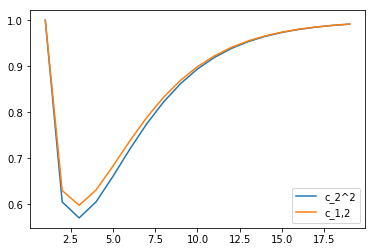

Inequality holds!


True

In [14]:
# Alphabet sizes that should be displayed in the plot.
PLOT_RANGE = range(1, 20)
# Alphabet sizes to check to see if the inequality holds.
INEQ_RANGE = range(1, 101)

util.plot_comparison(ALPH_SIZES, c_2_squared, c_12, 'c_2^2', 'c_1,2', 'lower right')
is_less_or_equal(INEQ_RANGE)

In [6]:
def first_num(a):
    return 8 ** a - 2 * 6 ** a + 5 ** a

def second_num(a):
    return (16 ** a - 2 * 12 ** a + 9 ** a) / (2 ** a - 1)

def third_num(a):
    return 8 ** a - 6 ** a

def fourth_num(a):
    return 10 ** a - 9 ** a

def fifth_num(a):
    return 10 ** a - 9 ** a - 8 ** a + 6 ** a

-1
-9
-25
639
15959
253071
3399815
41855679
488439479


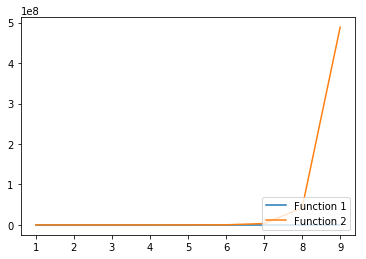

In [8]:
ALPH_SIZES = range(1, 10)

for a in ALPH_SIZES:
    print fifth_num(a)

util.plot_comparison(ALPH_SIZES, lambda x: 0, fifth_num, legend_loc='lower right')